In [1]:
# First we start loading our favourite packages with the names we used to
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
# import regression package
import statsmodels.api as sm

# Out of sample analysis

* In Chapter 11 we saw how in sample results are often a poor guide to how things behave out of sample

* The abit of lookign for large t-stats only partially guard agaisnt that because you will be searching for things that have high t-stats and you are bound to find high t-stat strategies **in sample** even if no true large alpha strategy exists.

* the literature on the biases that the "strategy discovery" process creates is vast and growing and plagues lots and lots of fields beyond investing where data is costly to generate (you cannot ask the market to rerun the last 100 years!)

**Literature **

* [False (and Missed) Discoveries in Financial Economics](https://faculty.fuqua.duke.edu/~charvey/Research/Published_Papers/P143_False_and_missed_OL.pdf)

* [Predicting Anomaly Performance with Politics, the Weather, Global Warming, Sunspots, and the Stars](http://rnm.simon.rochester.edu/research/PPiCToAPA.pdf) by Rober Novy Marx

* [A comprehensive look at the empirical performance of equity premium prediction](https://academic.oup.com/rfs/article-abstract/21/4/1455/1565737)

Inspecting whether your discovery is **TRUE** or just a statistical abnormality is science as much as it is art. 

Patterns that are so statisitcally reliable that eveyone can easily detect are unlikely to stay for long unless it is compensation for true risk. 

So you are unlikely to find something that makes sense only based on the stats and you will need to use your **economic logic** to evalaute if you cna understand why the premium is as high as it is. We will discuss this less "quantitative" part of the process in the chapter Equilibrium Thinking.

Here we will highlight the problem and discuss a few statistical techiniques.

Here are a few Twitter threads from people in the industry about this

* [someone tells you they have a strategy with a Sharpe of S. What questions should you be asking about the strategy to verify that it's real?](https://twitter.com/macrocephalopod/status/1359810769433616384)

* [overfiting](https://twitter.com/macrocephalopod/status/1362165448205295620?s=20)

It has this really nice plot

![outofsample](../../assets/plots/outofsample1.jpg)


> What does it tell us?

* [The dumbest strategy ever created](https://imarketsignals.com/2021/outperforming-the-sp-500-with-50-consensus-stock-holdings-of-40-large-hedge-funds/)

* [We are always looking for patterns, be careful!](https://twitter.com/nope_its_lily/status/1368623837961621505)

**Estimation and Test Samples**

Last chapter we used MV logic to constuct a portfolio with the maximum SR.

To evaluate whether this approach works well in the data what can we do?

Jsut looking at the sample where we did the estiamtion is not a realistic description of how you actually deploy the strategy whcih will have to trade on data that was was never seen/digested by your methodology

One way to do it is to split the sample in two:

* **Estimation sample**: This is the sample we will use to estimate moments, construct the portfolios, and so on. That is where your discovery process will take place. Where you will play with different parameters of the strategy. Statistical tests here are not valid


* **Test sample**: You will use this to run statistical test and see how your meothod to construct weights .






In [90]:
def SR(R,W=[],freq=12):
    if np.empty(W):
        sr=R.mean()/R.std()*freq**0.5
    else:
        r=R@W
        sr=r.mean()/r.std()*freq**0.5
    return sr

**Aplication 1: optimal combitation of market and value strategies**

Below is our full sample optimal portfolio

We will split our sample into two halves:  
 1. take all observations from odd months in even years and even months in odd years (i.e., if starting in 1980, this would look like:  01/1980, 03/1980, . . . , 11/1980, 02/1981, 04/1981, . . . 12/1981, 01/1982, 03/1982, . . .); and 
 2.  the opposite (take all observations from even months in even years and odd months in odd years).

A nice thing to do in halves is that we can cross-validated  use first sample 1 as estiamtion sample and sample2 as test sample, and then invert

If you have lot of data one migh split the data in 5 folds and do the estimation in one and test on the rest.


In [2]:
# loading the data
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
ds_names=get_available_datasets()
from datetime import datetime
start = datetime(1926, 1, 1)
ds = web.DataReader(ds_names[0], 'famafrench',start=start)
df=ds[0][:'2021-3']
df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.30,-2.87,0.22
1926-08,2.64,-1.40,4.19,0.25
1926-09,0.36,-1.32,0.01,0.23
1926-10,-3.24,0.04,0.51,0.32
1926-11,2.53,-0.20,-0.35,0.31
...,...,...,...,...
2020-11,12.47,5.48,2.11,0.01
2020-12,4.63,4.81,-1.36,0.01
2021-01,-0.03,7.19,2.85,0.00


In [68]:
W=df[['Mkt-RF','HML']].mean()@np.linalg.inv(df[['Mkt-RF','HML']].cov())
# formula for unlevereaged portfolio vol
vol_unlevered=(df[['Mkt-RF','HML']].mean()@np.linalg.inv(df[['Mkt-RF','HML']].cov())@df[['Mkt-RF','HML']].mean())**0.5
W_lev=W*(df['Mkt-RF'].std()/vol_unlevered)
Optimalportfolio= df[['Mkt-RF','HML']] @ W_lev
SR(Optimalportfolio)

0.5010016962253796

Letss construct both samples by using a function that returns `True` if the number is odd and then apply this function to the months and years of our dataset.

In [74]:
def is_odd(num):
    return num % 2 != 0

evenyear_oddmonth=(is_odd(df.index.year)==False) & (is_odd(df.index.month)==True)
oddyear_evenmonth=(is_odd(df.index.year)==True) & (is_odd(df.index.month)==False)

sample1=evenyear_oddmonth | oddyear_evenmonth
# sample2 is just the opposite of sample 1.What is true becomes false and what is false becomes true
sample2=~sample1

Lets construct a function that takes the sample and returns the SR

In [91]:
def Strategy(df1,estsample):
    W=df1[estsample].mean()@np.linalg.inv(df1[estsample].cov())
    # formula for unlevereaged portfolio vol
    vol_unlevered=(df1[estsample].mean()@np.linalg.inv(df1[estsample].cov())@df1[estsample].mean())**0.5
    W_lev=W*(df1['Mkt-RF'][estsample].std()/vol_unlevered)
    Optimalportfolio= df1[~estsample] @ W_lev
    return SR(Optimalportfolio)
print('Optimal portfolio perfomance in sample 2 (estimation sample 1)')
print(Strategy(df[['Mkt-RF','HML']],sample1))
print('Market perfomance in sample 2')
print(SR(df[['Mkt-RF']][sample2]))
print('Optimal portfolio perfomance in sample 1 (estimation sample 2)')
print(Strategy(df[['Mkt-RF','HML']],sample2))
print('Market perfomance in sample 1')
print(SR(df[['Mkt-RF']][sample1]))


Optimal portfolio perfomance in sample 2 (estimation sample 1)
0.5398648872236791
Market perfomance in sample 2
Mkt-RF    0.502882
dtype: float64
Optimal portfolio perfomance in sample 1 (estimation sample 2)
0.4543626900658743
Market perfomance in sample 1
Mkt-RF    0.386996
dtype: float64


In terms of Sharpe Ratios it seems to pass the test.

But this is simply one number. We can use our regression approach to formally test if indeed the optimal portfolio is likely to add value to the market

Lets modify our function to include the estimation of the alpha

While we are at it I will also add a `results` container so I can store the test sample SR and vol of the optimal portfolio and the market and the alpha and t-value as well

In [97]:
results=pd.Series([],index=[],dtype=float)
results.at['test']=1.6
results

test    1.6
dtype: float64

In [115]:
def Strategy(df1,estsample):
    results=pd.Series([],index=[],dtype=float)
    W1=df1[estsample].mean()@np.linalg.inv(df1[estsample].cov())
    # formula for unlevereaged portfolio vol
    vol_unlevered=(df1[estsample].mean()@np.linalg.inv(df1[estsample].cov())@df1[estsample].mean())**0.5
    W_lev=W1*(df1['Mkt-RF'][estsample].std()/vol_unlevered)
    Optimalportfolio= df1[~estsample] @ W_lev
    results.at['Optimal:SR']=SR(Optimalportfolio)
    results.at['Optimal:std']=Optimalportfolio.std()*12**0.5
    results.at['MKT:SR']=SR(df1[~estsample]['Mkt-RF'])
    results.at['MKT:std']=df1[~estsample]['Mkt-RF'].std()*12**0.5
    # now run the regression
    x= sm.add_constant(df1[~estsample]['Mkt-RF'])
    y= Optimalportfolio.copy()
    regresult= sm.OLS(y,x).fit()
    results.at['alpha']=regresult.params[0]
    results.at['t(alpha)']=regresult.tvalues[0]
    
    return results
print('Results for  test sample 2 (estimation sample 1)')
print(Strategy(df[['Mkt-RF','HML']],sample1))
print('Results for  test sample 1 (estimation sample 2)')
Strategy(df[['Mkt-RF','HML']],sample2)

Results for  test sample 2 (estimation sample 1)
Optimal:SR      0.539865
Optimal:std    18.266698
MKT:SR          0.502882
MKT:std        18.065852
alpha           0.171085
t(alpha)        1.452817
dtype: float64
Results for  test sample 1 (estimation sample 2)


Optimal:SR      0.454363
Optimal:std    18.799615
MKT:SR          0.386996
MKT:std        18.989705
alpha           0.156391
t(alpha)        1.701049
dtype: float64

We see several intersting things

* The vol targeting works pretty well out of sample. Our portfolio ended up with a similar vol to the market. 

> Why is that? Is it surprising/expected? Do you expect to do as well in vol targeting in real life trading? Why why not?

* The alphas are there (given that the SR were higher , this mechanically means that the alphas would be non zero), but the t-values do not suggest this was a super robust feauture of the data. 

* What does that mean? It means that $\sigma(r^{optimal}_t-\beta r^{mkt}_t)$ was sufficienly volatile in the test sample that there is a greater than 10% change that the market is tangency in sample 2 and a slight lower than 10% chance that is tangency in sample 1.

* this is not bad, but it is not good either. If both were above 2 it would be prettry solid.

**How to split your sample**

* You can split the sample in a variety of ways. I did a fancy one above just to showcase it.

* But I would typically recommend to keep it simple and simply split the sample down the middle.

* This has the advantage of keeping any non-homocedastic features of the data intact. For example, volatiltiy is highly clustered, so when we split the way we split above we are almost makign sure that the volatiltiy is about the same in both months. So this is not a great method to split if your strategy really depends on timing volaitltiy well.

* You don't even need to split the samples equally, but you have to have in mind that a long sample is useful to both get precise point estimates (so you need a long estiamtion sample), but a logn sample is also required to have enought power to test. IF you make the test sample too short, you are guarantteing that you will fail to reject your reference portfolio

**Fine tuning your strategy**

We know have three piece of data. 

* **Estimation sample**: The estiamtion sample is exactyl as before. This is the sample we will use to estimate moments, construct the portfolios, and so on. That is where your discovery process will take place. Where you will play with different parameters of the strategy. Statistical tests here are not valid

But now the Test sample will change and we will introduce the concept of the hold out sample

* **Test sample**: You will use this to run statistical test and see how a particular parameter configuration works on unseen data. In practice you will do the testing multiple times. For example in this example we will play with the look back windown of the covariance estimator, mean estimator and so on. 

    - So information of the test sample will leak to your method as you do the search.
    
    - You might settle on a particular specification becasue it worked on this particular sample, but not becasuse it is the most robust out of sample
    
    - So when you are searching for the specification that works you have the be very careful to not search "TOO MUCH"" so you are overfitting the Test sample
    
* **Holdout sample**: This is data that your method never looked. That is the true test. You only look at it once you are confident you have a good specification. The hold sample are a much closer reflection of the reality of trading.
    - of course it is impossible to really reproduce the reality of trading on future data and information of the holdout sample might leak through the fact that the researcher know what happened in that sample: there was a fiancial crash, a crypto boom, value did poorly and so on. 
    - This knowledge migth implicly guide your search process. 
    - So you have to be mindful of why you are makign the choices you are making to gaurd against this form of **look-ahead bias**

**Aplication 2: fine-tuning the look-back window**

Once you start playing with the look-back window that we use to estimate our moments we will need to figure out what works.

The trade-off here is:

 - If you make to short you jsut pick up noise
 - If you make too long the moments might not be that informative about future data
 - Particularly true in he case of volatility, but also true for correlations
 
 
 We will split the sample in two. The first half will be estiamtion+test, second hald will be hold out
 
 

In [123]:
df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.30,-2.87,0.22
1926-08,2.64,-1.40,4.19,0.25
1926-09,0.36,-1.32,0.01,0.23
1926-10,-3.24,0.04,0.51,0.32
1926-11,2.53,-0.20,-0.35,0.31
...,...,...,...,...
2020-11,12.47,5.48,2.11,0.01
2020-12,4.63,4.81,-1.36,0.01
2021-01,-0.03,7.19,2.85,0.00


In [131]:
sample1=df.index<=df.iloc[int(np.floor(df.shape[0]/2))].name
sample2=df.index>df.iloc[int(np.floor(df.shape[0]/2))].name

In [133]:

print('Results for  test sample 2 (estimation sample 1)')
print(Strategy(df[['Mkt-RF','HML']],sample1))
print('Results for  test sample 1 (estimation sample 2)')
Strategy(df[['Mkt-RF','HML']],sample2)

Results for  test sample 2 (estimation sample 1)
Optimal:SR      0.644581
Optimal:std    11.635633
MKT:SR          0.500860
MKT:std        15.859210
alpha           0.258585
t(alpha)        2.764342
dtype: float64
Results for  test sample 1 (estimation sample 2)


Optimal:SR      0.449700
Optimal:std    28.292410
MKT:SR          0.406965
MKT:std        20.866012
alpha           0.185466
t(alpha)        1.308342
dtype: float64

* We can already see that the volatility targeting aspect worked substantially less wll. We undershoot the volatiltiy in sample 2 and overshoot by a lot in sample 

* We will now do the estimation fine-tuning. Lets start by building a code that gets our desired window, do the estiamtion and construct the return series on the test sample

* lets start with 36 months

<AxesSubplot:xlabel='Date'>

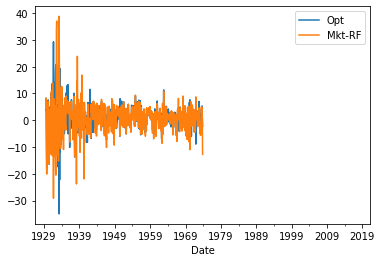

In [155]:

estsample=sample1
window=36
Returns_test=pd.DataFrame([],index=df.index,dtype=float)
df1=df[['Mkt-RF','HML']][estsample].copy()
results=pd.Series([],index=[],dtype=float)
for d in df1.index[window:]:
    df_temp=df1[d-window:d].copy()
    W1=df_temp.mean()@np.linalg.inv(df_temp.cov())
    vol_unlevered=(df_temp.mean()@np.linalg.inv(df_temp.cov())@df_temp.mean())**0.5
    W_lev=W1*(df_temp.std()/vol_unlevered)
    Returns_test.at[d,'Opt']= df1.loc[d] @ W_lev
    Returns_test.at[d,'Mkt-RF']= df1.loc[d,'Mkt-RF']

    
Returns_test.plot()


- Note that we have no observations early on as we need at the 36 months to estimate and none in the second half, that is the sample that we will hold out

- Now that we have this code we can put ina function and simply evaluate at a whole unch of different windows

<AxesSubplot:xlabel='Date'>

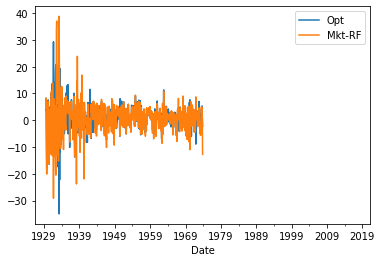

In [159]:
def RollingEval(df,window,estsample):
    Returns_test=pd.DataFrame([],index=df.index,dtype=float)
    df1=df[['Mkt-RF','HML']][estsample].copy()
    for d in df1.index[window:]:
        df_temp=df1[d-window:d].copy()
        W1=df_temp.mean()@np.linalg.inv(df_temp.cov())
        vol_unlevered=(df_temp.mean()@np.linalg.inv(df_temp.cov())@df_temp.mean())**0.5
        W_lev=W1*(df_temp.std()/vol_unlevered)
        Returns_test.at[d,'Opt']= df1.loc[d] @ W_lev
        Returns_test.at[d,'Mkt-RF']= df1.loc[d,'Mkt-RF']
    return Returns_test

Returns_test=RollingEval(df,36,sample1)        
Returns_test.plot()


In [162]:
windows=[24,36,48,60,72]
results=pd.DataFrame([],index=[],columns=windows,dtype=float)
for w in windows:
    Returns_test=RollingEval(df,w,sample1)    
    results.at['Optimal:SR',w]=SR(Returns_test.Opt)
    results.at['Optimal:std',w]=Returns_test.Opt.std()*12**0.5
    results.at['MKT:SR',w]=SR(Returns_test['Mkt-RF'])
    results.at['MKT:std',w]=Returns_test['Mkt-RF'].std()*12**0.5
    # now run the regression
    x= sm.add_constant(Returns_test['Mkt-RF'])
    y= Returns_test.Opt.copy()
    regresult= sm.OLS(y,x,missing='drop').fit()
    results.at['alpha',w]=regresult.params[0]
    results.at['t(alpha)',w]=regresult.tvalues[0]
    
results

,24,36,48,60,72
Optimal:SR,0.729121,0.662446,0.559205,0.613927,0.604021
Optimal:std,18.261577,17.478699,17.143940,16.599580,14.608167
MKT:SR,0.376006,0.349442,0.395631,0.442297,0.599587
MKT:std,21.156627,21.225400,20.875629,20.531663,19.393643
alpha,1.168284,0.956486,0.690608,0.703350,0.426639
t(alpha),5.165939,4.350827,3.221188,3.379011,2.449945


From this it seems that 24 looks best.

We will now look at how the 24 performed in the **Hold out sample**

In [163]:
windows=[24]
results=pd.DataFrame([],index=[],columns=windows,dtype=float)
for w in windows:
    Returns_test=RollingEval(df,w,sample2)    
    results.at['Optimal:SR',w]=SR(Returns_test.Opt)
    results.at['Optimal:std',w]=Returns_test.Opt.std()*12**0.5
    results.at['MKT:SR',w]=SR(Returns_test['Mkt-RF'])
    results.at['MKT:std',w]=Returns_test['Mkt-RF'].std()*12**0.5
    # now run the regression
    x= sm.add_constant(Returns_test['Mkt-RF'])
    y= Returns_test.Opt.copy()
    regresult= sm.OLS(y,x,missing='drop').fit()
    results.at['alpha',w]=regresult.params[0]
    results.at['t(alpha)',w]=regresult.tvalues[0]
    
results

,24
Optimal:SR,1.093922
Optimal:std,13.521201
MKT:SR,0.545364
MKT:std,15.462008
alpha,0.989791
t(alpha),6.354080


* Even better!

* That is pretty good

* you can see the t-stat goign through the roof and the SR of the optimal portfolio is almost twice as large as only investing in the market

* Note that here the bulk of the gains are form **Timing across these factors**. 

* You might also look to time between cash and this optimal portfolio

* The idea would be exactyl the same. You get a signal for the expected return and/or volatiltiy of the optimal portfolio
   - You already have one here, but the fact that the 24 months worked great to time across factors does not mean that it will work great to time between the factor and cash
   - But you would have some way to decide the weigths perhaps based on the mean-variance criteria, see how it works in the test sample across a variety of signal specifications and then you would ultimaterly test on the hold out sample
   
   

**Publication bias (or Famous bias or incubation bias...)**


We discussed that we often look at past perfomance exactly becasue a strategy did well. This mechanism of selection renders our statisitcal analysis biased in the direction of findings that the strategy is amazing.

It is often hard to deal with this becasue you need all the data of strategies that look like the one you are interested from the perspective of someone in the start of the relvant sample. That is hard.

One way to deal with this is to use some hard metric of saliency. For example, in chapter we used google trends to see when Bitcoin became popular and we did our analysis after that.

You could imagine doing that for fund managers as well. While google trends is only available after 2004 there is data from New York Times and Wall Street Journal that allows you to go back to the start of the **Last** century. ([for example, I use data like that that in this paper](http://www.google.com/url?q=http%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS0304405X16301751&sa=D&sntz=1&usg=AFQjCNFWO63SSQXSteNhgTI4oOhtmh0ZUQ))

A setting where we can do this very cleanly is in the context of acadmic work. We know exactyl when the paper was first published and what the sample that was used there

A nice paper that investigates this for a bunch of strategies is [Does academic research destroy stock return predictability?](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jofi.12365?casa_token=gSqvouNM61EAAAAA:JyTl4yxx9xTfKo8-VEBIE-4c4ha7kRFGvirWzEZRXhYw2AtueM3yzpRDcpcXgnsDdlvlXflKp1Nw_ss)

**Aplication: Evalauting the publication bias in Fama French 1996, Multifactor Anomalies...**

Teh original paper has the followign key table


![outofsample](../../assets/plots/outofsample2.jpg)

* You see here that the sample runs from 63 to 93. Back in 93 we didn't have digitalized accounting data that went back to the 30's

* Looking at the very last row we see that the alpha of the HML withresepect to HML is enormous, 0.56% per month, and it has a negative beta with the market!

* so now we will look at two different samples that the authors never looked before doing their study.

    * The pre 63 sample
    * the post 93. 
    
    


In [169]:
sample1=df.index<df.loc['1963-7'].name
sample2=df.index>df.loc['1993-12'].name
sample3=((df.index>=df.loc['1963-7'].name) &(df.index<=df.loc['1993-12'].name))

In [179]:
def Strategy(df1,sample):
    results=pd.Series([],index=[],dtype=float)
    x= sm.add_constant(df1[sample]['Mkt-RF'])
    y= df1[sample]['HML'].copy()
    regresult= sm.OLS(y,x).fit()
    results.at['HML:SR']=SR(y)
    results.at['MKT:SR']=SR(df1[sample]['Mkt-RF'])
    results.at['alpha']=regresult.params[0]
    results.at['beta']=regresult.params[1]
    results.at['t(alpha)']=regresult.tvalues[0]
    results.at['AR']=regresult.tvalues[0]/regresult.resid.std()
    W=df1[sample].mean()@np.linalg.inv(df1[sample].cov())
    W=W/np.sum(W)
    results.at['HML weight on MVE']=W[1]

    return results
print('Pre publication sample')
print(Strategy(df[['Mkt-RF','HML']],sample1))
print('Publication sample')
print(Strategy(df[['Mkt-RF','HML']],sample3))
print('Post publication sample')
print(Strategy(df[['Mkt-RF','HML']],sample2))


Pre publication sample
HML:SR               0.346962
MKT:SR               0.457366
alpha                0.113160
beta                 0.371094
t(alpha)             0.661317
AR                   0.185219
HML weight on MVE    0.342709
dtype: float64
Publication sample
HML:SR               0.608203
MKT:SR               0.325699
alpha                0.542778
beta                -0.207224
t(alpha)             4.257801
AR                   1.755981
HML weight on MVE    0.696805
dtype: float64
Post publication sample
HML:SR               0.079270
MKT:SR               0.580553
alpha                0.113256
beta                -0.054502
t(alpha)             0.637514
AR                   0.201533
HML weight on MVE    0.228248
dtype: float64


**what do we learn?**

* In the Pre-publication sample HML has a respectable SR, but the asset is much more correlated with the market so it's betas with respect to the market leaves only a statistically insignifcant 0.37% per month, 1.2% per year.

* Thus in the pre-sample the HML has a nice SR but the CAPM works so you would not have gained/lost too much of tilting your portfolio towards the HML strategy

* In the post-publication sample the results are very ugly
    - Sharpe ratio is now 0.08--compared with the 0.58 SR on the market
    - the alpha is still about the same as in the pre-publication, but now the betas become negative
    - the HML premium goes away almost completely
    
    
To have a sense of the shift we can look at the risk-return trade-off of the market and HML across samples.
 
* The optimal weight on HML shifts from 0.72 in the publication sample to 0.34 in the pre publication and 0.2 in the post publication

* someone that jsut invested on the market would be actually be closer to the optimal portfolio than someone that invested 0.7 in HML

**Does that mean it was data snooping?**

We don't know. It is possible that the publication drove people to the strategies which made the resuls go away goign forward. This [paper](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jofi.12365?casa_token=gSqvouNM61EAAAAA:JyTl4yxx9xTfKo8-VEBIE-4c4ha7kRFGvirWzEZRXhYw2AtueM3yzpRDcpcXgnsDdlvlXflKp1Nw_ss) I cited before argues that this is the case 



 